### Setup for Google Colab

If you are running this notebook in Google Colab, complete the following steps:

1. In Colab, we recommend going to **Runtime → Change runtime type** and selecting **T4 GPU**
2. Install **TerraTorch** and the required packages
3. Download the dataset (as part of the notebook)

In [ ]:
!pip install terratorch==1.2.1
!pip install gdown tensorboard
!pip install -U jupyter ipywidgets

------------

## Notebook: Segmentation Task in TerraTorch (Sen1Floods11)

This demo notebook shows how to use TerraTorch for a downstream semantic segmentation task using the Sen1Floods11 dataset.

Sen1Floods11 is a multimodal flood-mapping dataset that provides Sentinel-2 L1C optical imagery, Sentinel-1 GRD SAR data, and binary segmentation masks as labels. In this notebook, we focus exclusively on the Sentinel-2 L1C input modality. For examples that combine both Sentinel-1 and Sentinel-2 modalities, check out the multimodal examples folder.

### Data Exploration

We begin by downloading the dataset and performing a brief data exploration.

In [3]:
import os
import gdown
from pathlib import Path

if not os.path.isfile("sen1floods11_v1.1.tar.gz"):
    gdown.download("https://drive.google.com/uc?id=1lRw3X7oFNq_WyzBO6uyUJijyTuYm23VS")
    !tar -xzf sen1floods11_v1.1.tar.gz

dataset_path = Path("sen1floods11_v1.1")
!ls "sen1floods11_v1.1/data"

CopernicusDEM   LabelHand       S1OtsuLabelHand
JRCWaterHand    S1GRDHand       S2L1CHand


We instantiate the datamodule, the object we will use to load the files from disk to memory. For this task, we use the `GenericNonGeoSegmentationDataModule`, which is designed for standard segmentation workflows in TerraTorch.

In [4]:
import albumentations as A
from terratorch.datamodules import GenericNonGeoSegmentationDataModule

datamodule = GenericNonGeoSegmentationDataModule(
    batch_size=8,
    num_workers=0,

    # We use the same roots for train/val/test and select samples via the given split files
    train_data_root=dataset_path / "data/S2L1CHand",
    train_label_data_root=dataset_path / "data/LabelHand",
    val_data_root=dataset_path / "data/S2L1CHand",
    val_label_data_root=dataset_path / "data/LabelHand",
    test_data_root=dataset_path / "data/S2L1CHand",
    test_label_data_root=dataset_path / "data/LabelHand",

    # Split files
    train_split=dataset_path / "splits/flood_train_data.txt",
    val_split=dataset_path / "splits/flood_valid_data.txt",
    test_split=dataset_path / "splits/flood_test_data.txt",

    # File patterns inside the roots above
    img_grep="*_S2Hand.tif",
    label_grep="*_LabelHand.tif",

    # RGB visualization uses channels [R,G,B] = [3,2,1]
    rgb_indices=[3, 2, 1],
    num_classes=2,
)

# Call setup here so we can access dataset objects (e.g., datamodule.train_dataset) before training
datamodule.setup("fit")

In [6]:
val_dataset = datamodule.val_dataset

print(f"Available samples in the training dataset: {len(val_dataset)}")
print(f"Input shape of first sample: {val_dataset[0]['image'].shape}")

Available samples in the training dataset: 89
Input shape of first sample: torch.Size([13, 512, 512])


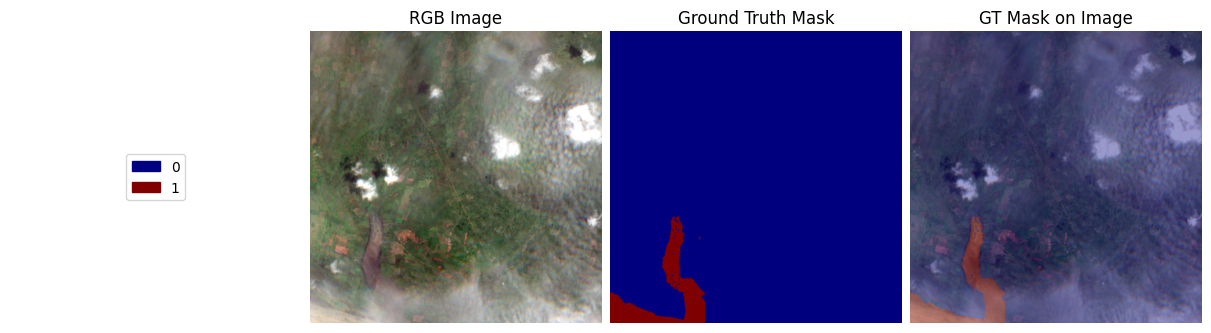

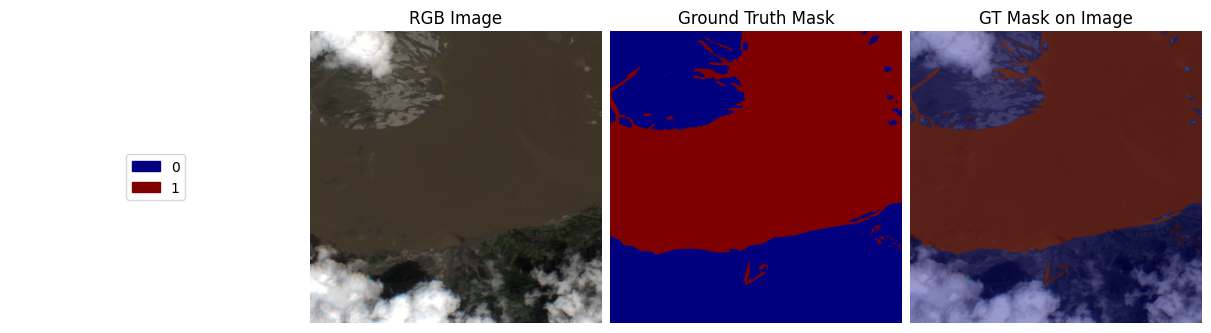

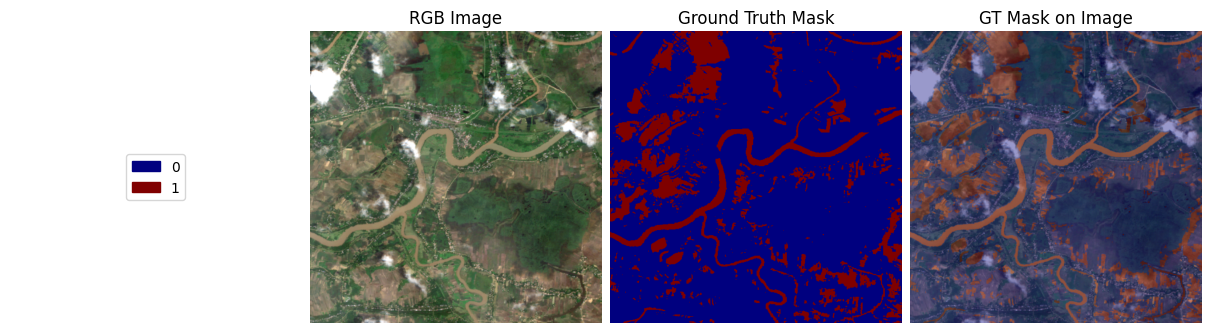

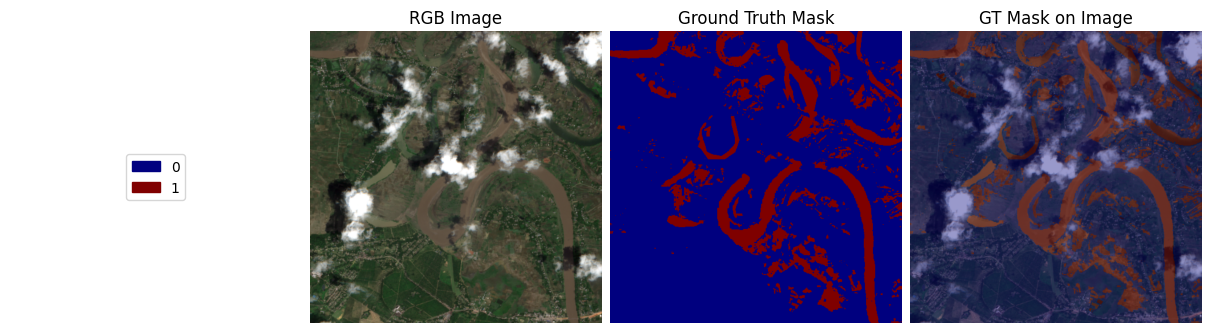

In [7]:
for i in range(10,14):
    _ = val_dataset.plot(val_dataset[i])

### The model backbone factory

Before building the full end-to-end training pipeline, we first inspect the available encoders via the backbone registry and demonstrate how to manually instantiate a backbone. Since we want to use a Prithvi model, we filter the registry to show only the available Prithvi backbones.

In [8]:
from terratorch.registry import BACKBONE_REGISTRY

prithvi_backbones = [
    name for name in BACKBONE_REGISTRY
    if "terratorch_prithvi" in name
]

print(f"Available TerraTorch Prithvi backbones ({len(prithvi_backbones)}):")
for name in prithvi_backbones:
    print(name)

Available TerraTorch Prithvi backbones (8):
terratorch_prithvi_eo_tiny
terratorch_prithvi_eo_v1_100
terratorch_prithvi_eo_v2_tiny_tl
terratorch_prithvi_eo_v2_100_tl
terratorch_prithvi_eo_v2_300
terratorch_prithvi_eo_v2_600
terratorch_prithvi_eo_v2_300_tl
terratorch_prithvi_eo_v2_600_tl


In [9]:
# Initialise one of the models
model = BACKBONE_REGISTRY.build("prithvi_eo_v2_100_tl")
print(model)

PrithviViT(
  (patch_embed): PatchEmbed(
    (proj): Conv3d(6, 768, kernel_size=(1, 16, 16), stride=(1, 16, 16))
    (norm): Identity()
  )
  (temporal_embed_enc): TemporalEncoder()
  (location_embed_enc): LocationEncoder()
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
   

`pretrained_bands` shows the bands used during pretraining, which correspond to the six HLS bands. Using `model_bands`, we can inspect which bands the currently initialized model expects as input. Since we did not specify a different band configuration, this matches the pretraining bands.

In [10]:
print("Band configuration summary:")
print(f"  Pretrained on bands : {model.pretrained_bands}")
print(f"  Using input bands   : {model.model_bands}")

Band configuration summary:
  Pretrained on bands : [<HLSBands.BLUE: 'BLUE'>, <HLSBands.GREEN: 'GREEN'>, <HLSBands.RED: 'RED'>, <HLSBands.NIR_NARROW: 'NIR_NARROW'>, <HLSBands.SWIR_1: 'SWIR_1'>, <HLSBands.SWIR_2: 'SWIR_2'>]
  Using input bands   : [<HLSBands.BLUE: 'BLUE'>, <HLSBands.GREEN: 'GREEN'>, <HLSBands.RED: 'RED'>, <HLSBands.NIR_NARROW: 'NIR_NARROW'>, <HLSBands.SWIR_1: 'SWIR_1'>, <HLSBands.SWIR_2: 'SWIR_2'>]


Next, we show the output shapes of the encoder using a dummy input. The model returns a list containing the outputs of each encoder layer, which may differ depending on the specific encoder architecture.

In [11]:
import torch

# Dummy input to probe the model's feature outputs
dummy_input = torch.zeros(1, 6, 224, 224)  # (batch, channels, height, width)

with torch.no_grad():
    features = model(dummy_input)

print("Extracted feature maps:")
for i, feat in enumerate(features):
    print(f"  Output layer {i+1}: shape = {tuple(feat.shape)}")

Extracted feature maps:
  Output layer 1: shape = (1, 197, 768)
  Output layer 2: shape = (1, 197, 768)
  Output layer 3: shape = (1, 197, 768)
  Output layer 4: shape = (1, 197, 768)
  Output layer 5: shape = (1, 197, 768)
  Output layer 6: shape = (1, 197, 768)
  Output layer 7: shape = (1, 197, 768)
  Output layer 8: shape = (1, 197, 768)
  Output layer 9: shape = (1, 197, 768)
  Output layer 10: shape = (1, 197, 768)
  Output layer 11: shape = (1, 197, 768)
  Output layer 12: shape = (1, 197, 768)


#### Band choice

In some cases, you may want to use a different set of input bands than those used during pretraining. This may be a different ordering, a subset, a superset, or a completely different set.

To do this, you can explicitly specify the bands to train on using a mixture of integer indices and members of the `HLSBands` enum.

In the patch embed layer, the weights corresponding to bands that exist in the pretrained bands will be mapped to the correct order. Bands that do not exist will be randomly initialized.

In [12]:
# Build a Prithvi ViT backbone with a custom band configuration
model = BACKBONE_REGISTRY.build(
    "prithvi_eo_v2_100_tl",
    num_frames=1,
    pretrained=True,
    bands=["GREEN", "RED", "BLUE", 5], # Select RGB bands in G–R–B order and add one extra (non-HLS) band
)

In [13]:
print("Band configuration summary:")
print(f"  Pretrained on bands : {model.pretrained_bands}")
print(f"  Using input bands   : {model.model_bands}")

Band configuration summary:
  Pretrained on bands : [<HLSBands.BLUE: 'BLUE'>, <HLSBands.GREEN: 'GREEN'>, <HLSBands.RED: 'RED'>, <HLSBands.NIR_NARROW: 'NIR_NARROW'>, <HLSBands.SWIR_1: 'SWIR_1'>, <HLSBands.SWIR_2: 'SWIR_2'>]
  Using input bands   : [<HLSBands.GREEN: 'GREEN'>, <HLSBands.RED: 'RED'>, <HLSBands.BLUE: 'BLUE'>, 5]


In [14]:
# The model now expects 4 input channels (GRB + one additional band)
trial_data = torch.zeros(1, 4, 224, 224)  # (batch, channels, height, width)

with torch.no_grad():
    features = model(trial_data)

print("Extracted feature maps:")
for i, feature in enumerate(features):
    print(f"  Output layer {i+1} {i}: shape = {tuple(feature.shape)}")

Extracted feature maps:
  Output layer 1 0: shape = (1, 197, 768)
  Output layer 2 1: shape = (1, 197, 768)
  Output layer 3 2: shape = (1, 197, 768)
  Output layer 4 3: shape = (1, 197, 768)
  Output layer 5 4: shape = (1, 197, 768)
  Output layer 6 5: shape = (1, 197, 768)
  Output layer 7 6: shape = (1, 197, 768)
  Output layer 8 7: shape = (1, 197, 768)
  Output layer 9 8: shape = (1, 197, 768)
  Output layer 10 9: shape = (1, 197, 768)
  Output layer 11 10: shape = (1, 197, 768)
  Output layer 12 11: shape = (1, 197, 768)


### EncoderDecoder model factory

Model factories allow us to create full models for specific tasks, including decoders and task-specific heads. They return standard `torch.nn.Module` objects that you can use anywhere in your code. We create a semantic segmentation model with 4 output classes.

In [15]:
from terratorch.models import EncoderDecoderFactory

model_factory = EncoderDecoderFactory()

# Build a segmentation model:
# - backbone_* args configure the encoder backbone
# - decoder_* args configure the decoder
# - head_* args configure the task head

model = model_factory.build_model(
    task="segmentation",
    backbone="prithvi_eo_v2_100_tl",
    backbone_pretrained=True,
    backbone_num_frames=1,
    backbone_bands=[
        "BLUE",
        "GREEN",
        "RED",
        "NIR_NARROW",
        "SWIR_1",
        "SWIR_2",
    ],
    decoder="FCNDecoder",
    decoder_channels=128,
    num_classes=4,
    head_dropout=0.2,
)

The forward pass returns a `ModelOutput` object, which contains the main `output` as well as the outputs of any `auxiliary_heads`.

In [16]:
# Run a forward pass with a dummy input
dummy_input = torch.zeros(1, 6, 224, 224)  # (batch, channels, height, width)

with torch.no_grad():
    out = model(dummy_input)

print(f"Output shape: {out.output.shape}")

Output shape: torch.Size([1, 4, 224, 224])


### Building the TerraTorch training pipeline

Next, we build the TerraTorch training pipeline for the Sen1Flood11 segmentation task by configuring the model, loss, optimizer, and training hyperparameters. 

At the highest level of abstraction, TerraTorch provides task-specific trainers. They build on the model factory introduced above and can be configured with any supported backbone, decoder, and head.

In [17]:
from terratorch.tasks import SemanticSegmentationTask

# Model configuration passed to the EncoderDecoderFactory
model_args = {
    "backbone": "prithvi_eo_v2_tiny_tl",
    "decoder": "FCNDecoder", # use a FCN decoder
    "num_classes": 2, # binary segmentation
    "backbone_pretrained": True,
    "decoder_channels": 64,
    "head_dropout": 0.2,

    # Neck configuration to adapt encoder outputs for the decoder
    "necks": [
        {"name": "SelectIndices", "indices": [-1]},   # use the last encoder layer output only
        {"name": "ReshapeTokensToImage"},             # convert ViT tokens to spatial feature maps
    ],
}

task = SemanticSegmentationTask(
    model_args=model_args,
    model_factory="EncoderDecoderFactory",
    loss="ce",
    lr=2e-5,
    ignore_index=-1,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.05},
)

We initialize a new datamodule with extended arguments. This filters the 13 input bands to the six expected HLS bands, applies data normalization using the Prithvi pretraining statistics, and adds training data transforms.

In [18]:
datamodule = GenericNonGeoSegmentationDataModule(
    batch_size=8,
    num_workers=0,

    train_data_root=dataset_path / "data/S2L1CHand",
    train_label_data_root=dataset_path / "data/LabelHand",
    val_data_root=dataset_path / "data/S2L1CHand",
    val_label_data_root=dataset_path / "data/LabelHand",
    test_data_root=dataset_path / "data/S2L1CHand",
    test_label_data_root=dataset_path / "data/LabelHand",

    train_split=dataset_path / "splits/flood_train_data.txt",
    val_split=dataset_path / "splits/flood_valid_data.txt",
    test_split=dataset_path / "splits/flood_test_data.txt",
    
    img_grep="*_S2Hand.tif",
    label_grep="*_LabelHand.tif",

    # Data transforms
    train_transform=[
        A.D4(),  # random flips and rotations to stabilize training
        A.pytorch.ToTensorV2(),
    ],
    val_transform=None,
    test_transform=None,

    # Band selection: input data is 13-channel Sentinel-2 L1C.
    # We select the 6-band subset used for Prithvi pretraining.
    # You can omit dataset_bands/output_bands if you do not want to filter channels.
    dataset_bands=[
        "COASTAL_AEROSOL",  # B01
        "BLUE",             # B02
        "GREEN",            # B03
        "RED",              # B04
        "RED_EDGE_1",       # B05
        "RED_EDGE_2",       # B06
        "RED_EDGE_3",       # B07
        "NIR_BROAD",        # B08
        "NIR_NARROW",       # B8A
        "WATER_VAPOR",      # B09
        "CIRRUS",           # B10
        "SWIR_1",           # B11
        "SWIR_2",           # B12
    ],
    output_bands=[
        "BLUE",
        "GREEN",
        "RED",
        "NIR_NARROW",
        "SWIR_1",
        "SWIR_2",
    ],

    # RGB visualization uses channels [R,G,B] = [2,1,0] (within output_bands below)
    rgb_indices=[2, 1, 0],

    # We use the Prithvi v2 pretraining values for normalizing the data (must match output_bands order)
    means=[1087.0, 1342.0, 1433.0, 2734.0, 1958.0, 1363.0],
    stds=[2248.0, 2179.0, 2178.0, 1850.0, 1242.0, 1049.0],

    num_classes=2,
    no_data_replace=0,
    no_label_replace=-1,
)

The Lightning `Trainer` manages the full training loop for us (training/validation steps, device placement, logging, and checkpointing).

Below is a minimal example that trains for a small number of epochs and saves the best checkpoint.

In [20]:
import os
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint, RichProgressBar
from lightning.pytorch.loggers import TensorBoardLogger

experiment = "tutorial"

os.makedirs("tutorial_experiments", exist_ok=True)
default_root_dir = os.path.join("tutorial_experiments", experiment)

logger = TensorBoardLogger(save_dir=default_root_dir, name=experiment)

checkpoint_callback = ModelCheckpoint(
    save_top_k=1,
    save_last=True,
)

trainer = Trainer(
    accelerator="auto",  # or specify cpu or gpu
    max_epochs=1,  # for demo purposes
    default_root_dir=default_root_dir,
    logger=logger,
    callbacks=[
        RichProgressBar(),
        checkpoint_callback,
        LearningRateMonitor(logging_interval="epoch"),
    ],
    log_every_n_steps=1,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


In [ ]:
# Run training
trainer.fit(model=task, datamodule=datamodule)

In [ ]:
# Run test loop
trainer.test(model=task, datamodule=datamodule)

### Inference

In [22]:
# Check the size of the test dataset
datamodule.setup("test")
test_dataset = datamodule.test_dataset

print(f"Available samples in the test dataset: {len(test_dataset)}")

Available samples in the test dataset: 90


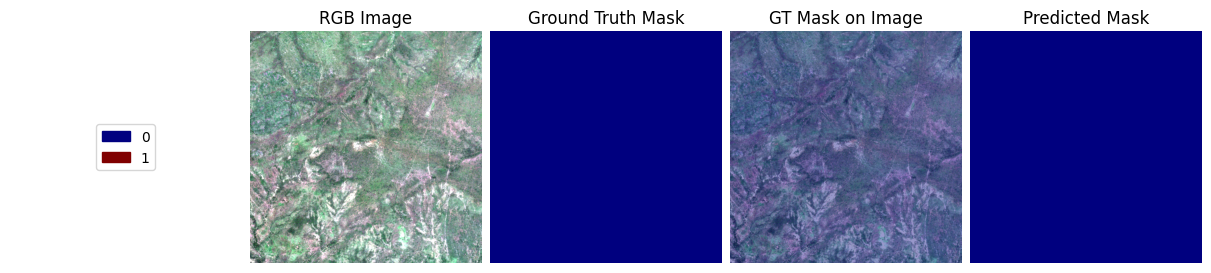

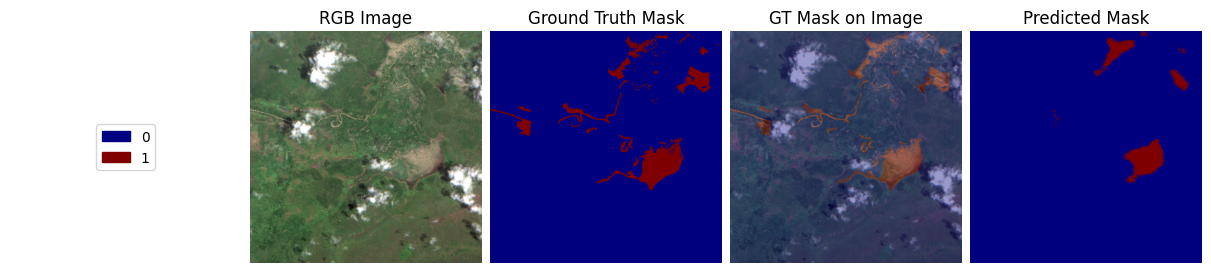

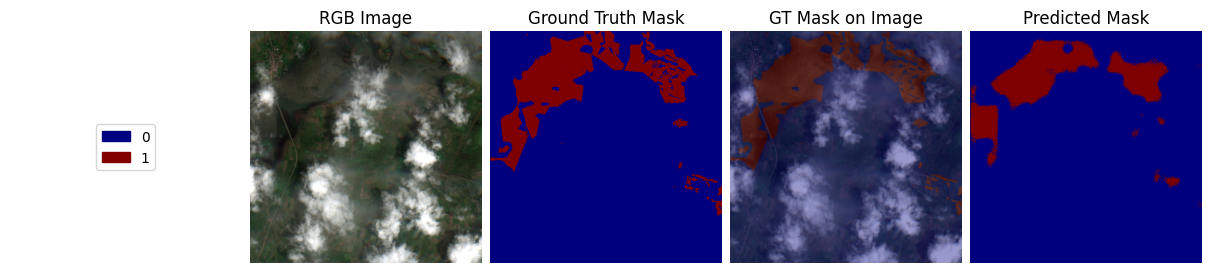

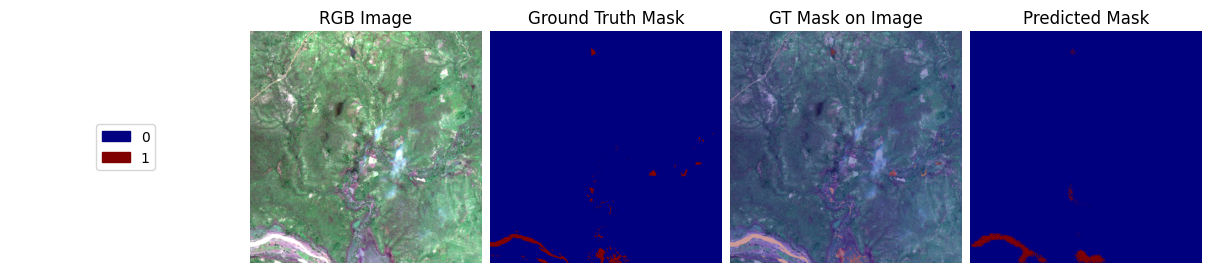

In [29]:
# Use the trained task for inference and visualization
task.eval()

# Get a batch from the test dataloader
datamodule.setup("test")
test_loader = datamodule.test_dataloader()

with torch.no_grad():
    batch = next(iter(test_loader))
    # Apply the same normalization used during training
    batch = datamodule.aug(batch)
    images = batch["image"].to(task.device)
    masks = batch["mask"].cpu().numpy()

    outputs = task(images)
    preds = torch.argmax(outputs.output, dim=1).cpu().numpy()

# Visualize a few predictions
num_examples = min(6, len(preds))
for i in range(2, num_examples):
    sample = {
        "image": batch["image"][i].cpu(),
        "mask": batch["mask"][i],
        "prediction": preds[i],
    }
    test_dataset.plot(sample)

## Training via CLI

Above, we introduced the required TerraTorch components and how to combine them flexibly. The same workflow can be run in a no-code setup by configuring all components in a YAML file and executing it via the PyTorch Lightning CLI.

We provide a sample YAML for the above workflow (Using a UNet instead of a FCN decoder) that can serve as a starting point for similar pipelines.

**Note:** You may want to restart the session to free up memory before running the CLI workflow.

In [ ]:
!terratorch fit -c segmentation_sen1floods11.yaml